In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

[link to the bike rental dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)

## Lets begin with day-wise analysis

In [2]:
data = pd.read_csv("./christophM_datasets/bike_sharing/day.csv")
display(data.head())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## data description

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not.
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling(**feels like**) temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

### Inferences and further operations
1. `cnt` is the dependent variable, to be predicted.
2. `instant` and `dteday` can be filtered out.
3. all categorical variables will now be treatment-coded.

In [3]:
# drop instant and dteday
data.drop(['instant', 'dteday'], axis=1, inplace=True)
display(data.head(10))

# checking datatypes for all features
print(data.dtypes)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [4]:
x = data['casual']+data['registered'] ==  data['cnt']
x.value_counts()

True    731
dtype: int64

Thus, casual+registered = total counts of bike rented for the day.\
Hence, we now have 2 problems, instead of 1.
1. predict, based on these environmental conditions, how many **casual renters** rented a bike on a day?
2. predict, based on these environmental conditions, how many **registered renters** rented a bike on a day?

In [5]:
print("categories for season:", data['season'].unique())
print("categories for year:", data['yr'].unique())
print("categories for month:", data['mnth'].unique())
print("categories for holiday:", data['holiday'].unique())
print("categories for weekday:", data['weekday'].unique())
print("categories for workingday:", data['workingday'].unique())
print("categories for weathersit:", data['weathersit'].unique())

categories for season: [1 2 3 4]
categories for year: [0 1]
categories for month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
categories for holiday: [0 1]
categories for weekday: [6 0 1 2 3 4 5]
categories for workingday: [0 1]
categories for weathersit: [2 1 3]


Weather situtation(`weathersit`) is actually an <u>ordinal variable</u>, since the encoding is based on the severity of weather.

In [6]:
categorical_features = [
    'season',
    'yr',
    'mnth',
    'holiday',
    'weekday',
    'workingday'
]

# notice categorical_features excludes weathersit.

for feature in categorical_features:
    treatment_mat = pd.get_dummies(data[feature], drop_first=True)
    current_categories = treatment_mat.columns
    treatment_mat.columns = ['{}_{}'.format(feature, i) for i in current_categories]
    data.drop([feature], axis=1, inplace=True)
    data = pd.concat([data, treatment_mat], axis=1)

print("after one-hot encoding all categorical features...")
display(data.head())

# label encode the weathersit feature

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['weathersit'] = le.fit_transform(data['weathersit'])

print("after label encoding the weathersit feature....")
display(data.head())

after one-hot encoding all categorical features...


,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,...,0,0,0,0,0,1,0,0,0,1


after label encoding the weathersit feature....


,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,1,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0.363478,0.353739,0.696087,0.248539,131,670,801,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,...,0,0,0,0,0,1,0,0,0,1


## normalize the numerical variables

In [7]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

numerical_features = [i for i in data.columns if i not in ['cnt', 'registered', 'casual']]
numerical_data = pd.DataFrame(mm.fit_transform(data.loc[:, numerical_features]), columns=numerical_features)

display(numerical_data.head())

,weathersit,temp,atemp,hum,windspeed,season_2,season_3,season_4,yr_1,mnth_2,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.5,0.379232,0.360541,0.715771,0.466215,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.171000,0.144830,0.449638,0.465740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.175530,0.174649,0.607131,0.284297,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.209120,0.197158,0.449313,0.339143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


as all features are now included, the `numerical_data` is actually the normalized important dataset.

In [8]:
normalized_data = numerical_data.copy()

## New feature interpretation

1. season_2, season_3, season_4 denote spring, summer and fall respectively.
    1. when all the 3 are 0, it means winter.
2. yr_1 means 2012, if 0 then thats 2011.
3. mnth_2 to mnth_12 means Feb-December, when all of these are 0s, it means January.
4. weekday_1 to weekday_6 means Monday to Saturday, all 0s means Sunday.
5. `weathersit_2` means
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
6. `weathersit_3` : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - when both are 0, it means Clear, Few clouds, Partly cloudy, Partly cloudy

### Divide the dataset into training and test sets

## we will be first dealing with casual renters

In [9]:
X, y = normalized_data, data['casual']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

the shape of x-train is (511, 28), y-train is (511,), x-test is (220, 28), y-test is (220,).


In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(x_train, y_train)

print("R\u00b2 for this basic model is {}".format(lr.score(x_test, y_test)))
# intercept, weights = 

R² for this basic model is 0.7433598107373678


In [11]:
from json import dumps
print(dumps(dict(zip(X.columns, lr.coef_)), indent=2))

{
  "weathersit": -251.39278463667495,
  "temp": 1299.553504933548,
  "atemp": -51.93481908805104,
  "hum": -438.1424257017377,
  "windspeed": -591.3545437201198,
  "season_2": 273.17823855731706,
  "season_3": 105.90880203368174,
  "season_4": 34.384327999900265,
  "yr_1": 295.23154443789673,
  "mnth_2": -40.73591991425755,
  "mnth_3": 252.44425618002563,
  "mnth_4": 227.41609458998025,
  "mnth_5": 214.1704734311444,
  "mnth_6": 106.92324632137714,
  "mnth_7": 67.47409344569849,
  "mnth_8": 145.1205665021809,
  "mnth_9": 317.6317953682465,
  "mnth_10": 401.70179812297465,
  "mnth_11": 160.93886858352872,
  "mnth_12": -11.549002662495244,
  "holiday_1": -46.56879129831572,
  "weekday_1": -128.40426231933702,
  "weekday_2": -190.65278806689128,
  "weekday_3": -187.5322152053242,
  "weekday_4": -157.1637852388829,
  "weekday_5": 24.732592218321525,
  "weekday_6": 224.48500347155047,
  "workingday_1": -592.4516673137724
}


* Since scikit-learn doesn't provide with the results of the estimates , i.e. mean value and std. error in the estimation of weights, we resort to `statsmodels`.

* OLS, i.e. ordinary least squares regression is used, from the [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS) module. 

In [12]:
import statsmodels.api as smapi

model = smapi.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 casual   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              148.0
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                   1.74e-214
Time:                        16:51:25   Log-Likelihood:                         -3740.4
No. Observations:                 511   AIC:                                      7535.
Df Residuals:                     484   BIC:                                      7649.
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [13]:
def create_dataframe_from_confidence_intervals(confid_interv):
    columns = ['feature', 'weight']
    num_features = confid_interv.shape[0]
    value_list = []
    for i in range(num_features):
        curr_row = confid_interv.iloc[i, :]
        value_list.append([curr_row['index'], curr_row[0]])
        value_list.append([curr_row['index'], curr_row[1]])
    df = pd.DataFrame(columns=columns, data=value_list)
    return df

# confidence intervals
confid_interv = results.conf_int().reset_index()
display(confid_interv.head())

,index,0,1
0,weathersit,-573.236167,-271.134633
1,temp,181.841143,2493.689421
2,atemp,-1059.172060,1213.503489
3,hum,-10.327161,437.890671
4,windspeed,-450.636813,-51.851946


it would be better, from the perspective of visualising weight plots, to sort all features in the decreasing order of the width of their confidence intervals.

,index,0,1,interv_width
0,weathersit,-573.236167,-271.134633,302.101533
1,temp,181.841143,2493.689421,2311.848277
2,atemp,-1059.172060,1213.503489,2272.675550
3,hum,-10.327161,437.890671,448.217832
4,windspeed,-450.636813,-51.851946,398.784867




decrease sorted confidence intervals dataframe....


,index,0,1,interv_width
1,temp,181.841143,2493.689421,2311.848277
2,atemp,-1059.172060,1213.503489,2272.675550
14,mnth_7,-186.394909,517.967738,704.362648
15,mnth_8,-113.754378,567.592160,681.346538
13,mnth_6,-101.334311,525.361198,626.695509


,feature,weight
0,temp,181.841143
1,temp,2493.689421
2,atemp,-1059.172060
3,atemp,1213.503489
4,mnth_7,-186.394909


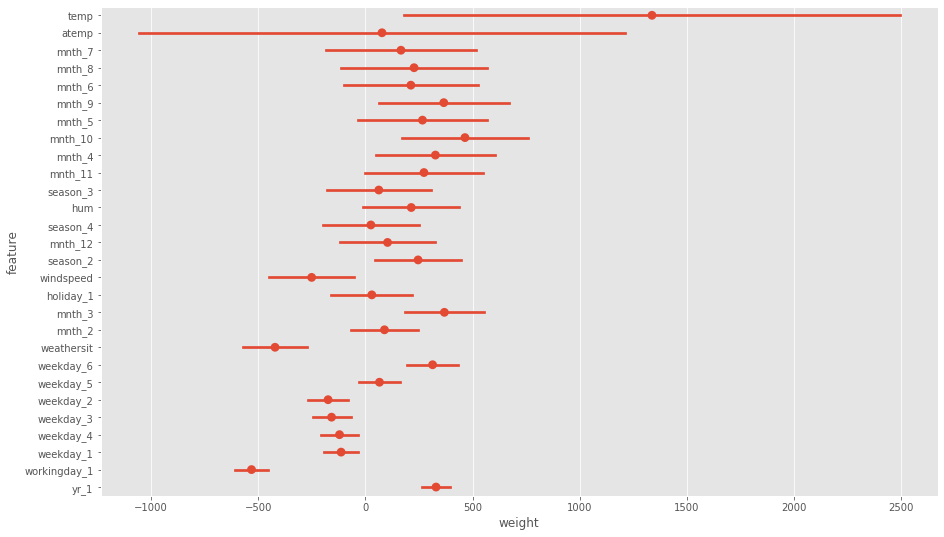

In [14]:
confid_interv['interv_width'] = abs(confid_interv[0]-confid_interv[1])
display(confid_interv.head())

# reverse sort the confidence intervals based on the order of their widths
confid_interv.sort_values(by='interv_width', ascending=False, inplace=True)
print("\n\ndecrease sorted confidence intervals dataframe....")
display(confid_interv.head())

modified_confid_interv = create_dataframe_from_confidence_intervals(confid_interv)
display(modified_confid_interv.head())

plt.style.use('ggplot')

plt.figure(figsize=(15, 9))
sns.pointplot(x="weight", y="feature", data=modified_confid_interv, join=False)

2. `yr_1` is the one with the least width of confidence interval, i.e. its weight is the easiest to determine.
    - notice that this has a high positive weight of 329.536(from results.summary()) hence if the year was 2011, a positive effect was observed on the number of casual renters, i.e. they increased.
    - this basically means that their sales on casual renters increased in 2011, as opposed to 2010.
    - this could be attributed to the fact that Capital Bikeshare could have become famous in 2011.


2. the `workingday_1`, i.e. whether the day was a working day or not had the least confidence interval, i.e. lest difficult to estimate its importance/weight.
    - its further observed that this feature has a negative weight, i.e. if its a work day, number of casual renters decreases.
    - this is quite logical, since such casual renters could be thought of as office goers(who have considerably high chances of being *registered* users) who rent out to occasionally go out for a bike ride, on non-working days.


3. `weekdays` are from 0-6, i.e. day of the week, from Monday to Sunday.
    - among these, weekday_5 and weekday_6, i.e. Saturday and Sunday have been given a positive large weights, with wider confidence intervals.
    - this can be supported by the generic logic that the propensity of people to bike during the weekends is greater since they don't have any job to go to.


4. `weathersit` has been given a **<font color="Red">negative weight</font>**, and has a wider confidence intervals than the features previously talked about.
    
    - it may be that many entries have a higher weathersit value, meaning bad/severe weather, and a corresponding lower `casual` value.
    - this could be explored by <font color="green">treating this as a nominal variable</font><font color="red"> rather than an ordinal one</font>.


5. `months`
    - are from 1 - 12, i.e. january to december.
    - as we go from february(`mnth_2`) to march(`mnth_3`), the weight and the width of the confidence interval changes, signifying that people love to rent out bikes and go when the season of spring arrives, i.e. pleasant weather.
    - again, `mnth_4` to `mnth_5`(april to may), the weight estimates decreases but the confidence interval width increases. this may signifiy that increasing heat of the environment is also a negative sign in terms of casual renters.
    - `mnth_10`, i.e. October, i.e. October-heat is where the weather gets pleasant again, is what may be the reason behind a large positive weight.
        - additionally, right from `mnth_7` to `mnth_10`, the weights increase but the confidence interval-width decreases.
        - this may mean bettering of weather is increasing renting propensity, and from the P.O.V. of the model, it becomes more clear to estimate the importance of a particular month.

    - 
1. `temp` and `atemp` have the largest confidence intervals.
    - `temp` has the largest weight, meaning the model thinks that temperature of the day was the most important factor in determining the number of casusal renters.
    - its quite weird that the model put a high **positive** weight on the temperature feature, whereas in reality it should have a negative impact.
    - this is unless lower temperatures mean **lower temperatures** , i.e. below 18$^{\circ}$C $\approx $
    - this could be checked by **<font color="Red">plotting histogram distributions and correlation plots for `temp vs casual` and `atemp vs casual`</font>**.


## Treating `weathersit` as a nominal variable.

In [15]:
new_X = X.copy()
new_X['weathersit'] = le.inverse_transform(data['weathersit'])
display(new_X.head())

ws_nominal_coded = pd.get_dummies(new_X['weathersit'], drop_first=True)
current_categories = ws_nominal_coded.columns
ws_nominal_coded.columns = ['{}_{}'.format('weathersit', i) for i in current_categories]
new_X.drop(['weathersit'], axis=1, inplace=True)
new_X = pd.concat([new_X, ws_nominal_coded], axis=1)

print("After nominal encoding of weather situation...")
display(new_X.head())

,weathersit,temp,atemp,hum,windspeed,season_2,season_3,season_4,yr_1,mnth_2,...,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1
0,2,0.355170,0.373517,0.828620,0.284606,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.379232,0.360541,0.715771,0.466215,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.171000,0.144830,0.449638,0.465740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0.175530,0.174649,0.607131,0.284297,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,0.209120,0.197158,0.449313,0.339143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


After nominal encoding of weather situation...


,temp,atemp,hum,windspeed,season_2,season_3,season_4,yr_1,mnth_2,mnth_3,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.355170,0.373517,0.828620,0.284606,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
1,0.379232,0.360541,0.715771,0.466215,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0.171000,0.144830,0.449638,0.465740,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,0.175530,0.174649,0.607131,0.284297,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0
4,0.209120,0.197158,0.449313,0.339143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0


the shape of x-train is (511, 29), y-train is (511,), x-test is (220, 29), y-test is (220,).
                                 OLS Regression Results                                
Dep. Variable:                 casual   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              142.6
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                   1.64e-213
Time:                        16:51:27   Log-Likelihood:                         -3740.1
No. Observations:                 511   AIC:                                      7536.
Df Residuals:                     483   BIC:                                      7655.
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                   coef    

,index,0,1
0,temp,196.127102,2510.617966
1,atemp,-1069.233064,1205.088299
2,hum,-23.313748,428.967520
3,windspeed,-447.256949,-47.775952
4,season_2,37.073202,443.519958


,index,0,1,interv_width
0,temp,196.127102,2510.617966,2314.490863
1,atemp,-1069.233064,1205.088299,2274.321364
2,hum,-23.313748,428.967520,452.281268
3,windspeed,-447.256949,-47.775952,399.480997
4,season_2,37.073202,443.519958,406.446756




decrease sorted confidence intervals dataframe....


,index,0,1,interv_width
0,temp,196.127102,2510.617966,2314.490863
1,atemp,-1069.233064,1205.088299,2274.321364
13,mnth_7,-183.494957,521.416225,704.911181
14,mnth_8,-114.862456,566.833566,681.696022
12,mnth_6,-99.945251,527.111454,627.056705


,feature,weight
0,temp,196.127102
1,temp,2510.617966
2,atemp,-1069.233064
3,atemp,1205.088299
4,mnth_7,-183.494957


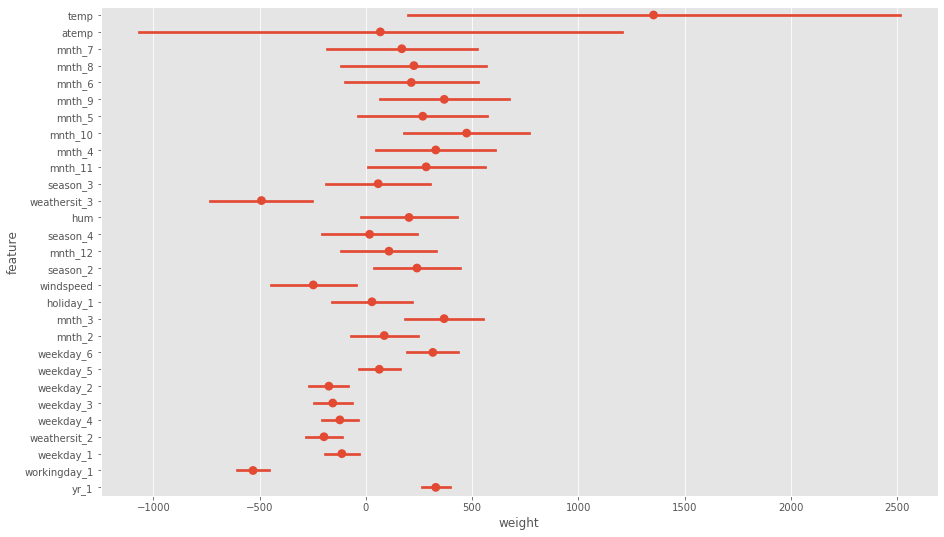

In [16]:
x_train, x_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=2021)
print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

model = smapi.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

# confidence intervals
new_confid_interv = results.conf_int().reset_index()
display(new_confid_interv.head())

new_confid_interv['interv_width'] = abs(new_confid_interv[0]-new_confid_interv[1])
display(new_confid_interv.head())

# reverse sort the confidence intervals based on the order of their widths
new_confid_interv.sort_values(by='interv_width', ascending=False, inplace=True)
print("\n\ndecrease sorted confidence intervals dataframe....")
display(new_confid_interv.head())

new_modified_confid_interv = create_dataframe_from_confidence_intervals(new_confid_interv)
display(new_modified_confid_interv.head())

plt.style.use('ggplot')

plt.figure(figsize=(15, 9))

sns.pointplot(x="weight", y="feature", data=new_modified_confid_interv, join=False)


## Effect plot

Construct the effect matrix from the weight vector and feature matrix.

In [17]:
weights = results.params
features = x_train.columns

effect_data = x_train.copy()

for feature in features:
    effect_data[feature] *= weights[feature]

In [18]:
display(effect_data.head(10))

,temp,atemp,hum,windspeed,season_2,season_3,season_4,yr_1,mnth_2,mnth_3,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
586,1174.897398,55.320874,129.395628,-68.227091,0.00000,57.752719,0.000000,328.796209,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-122.426797,0.00000,0.000000,-530.953199,-0.000000,-0.0
208,1214.247123,58.922393,121.661302,-79.646383,0.00000,57.752719,0.000000,0.000000,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-122.426797,0.00000,0.000000,-530.953199,-0.000000,-0.0
476,861.514459,41.358924,142.430775,-133.279651,240.29658,0.000000,0.000000,328.796209,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-0.000000,0.00000,314.879617,-0.000000,-0.000000,-0.0
508,948.644067,45.076268,161.548851,-40.621582,240.29658,0.000000,0.000000,328.796209,0.0,0.0,...,0.0,-0.0,-0.000000,-155.927324,-0.000000,0.00000,0.000000,-530.953199,-197.263042,-0.0
395,557.968109,26.949638,86.901049,-122.171112,0.00000,0.000000,0.000000,328.796209,0.0,0.0,...,0.0,-0.0,-174.146048,-0.000000,-0.000000,0.00000,0.000000,-530.953199,-0.000000,-0.0
99,619.802187,30.999475,178.842216,-63.464758,240.29658,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-0.000000,0.00000,0.000000,-0.000000,-197.263042,-0.0
8,133.564779,3.308472,90.550890,-173.265796,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-0.000000,0.00000,0.000000,-0.000000,-0.000000,-0.0
692,521.429560,26.723339,118.619837,-64.104634,0.00000,0.000000,17.557283,328.796209,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-0.000000,63.13003,0.000000,-530.953199,-0.000000,-0.0
167,995.019203,46.482476,153.467060,-61.557376,240.29658,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,-0.0,-0.000000,-0.000000,-0.000000,63.13003,0.000000,-530.953199,-0.000000,-0.0
122,940.212224,44.850415,145.385269,-163.426295,240.29658,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,-0.0,-174.146048,-0.000000,-0.000000,0.00000,0.000000,-530.953199,-197.263042,-0.0


,feature_name,effect
0,temp,1174.897398
1,temp,1214.247123
2,temp,861.514459
3,temp,948.644067
4,temp,557.968109


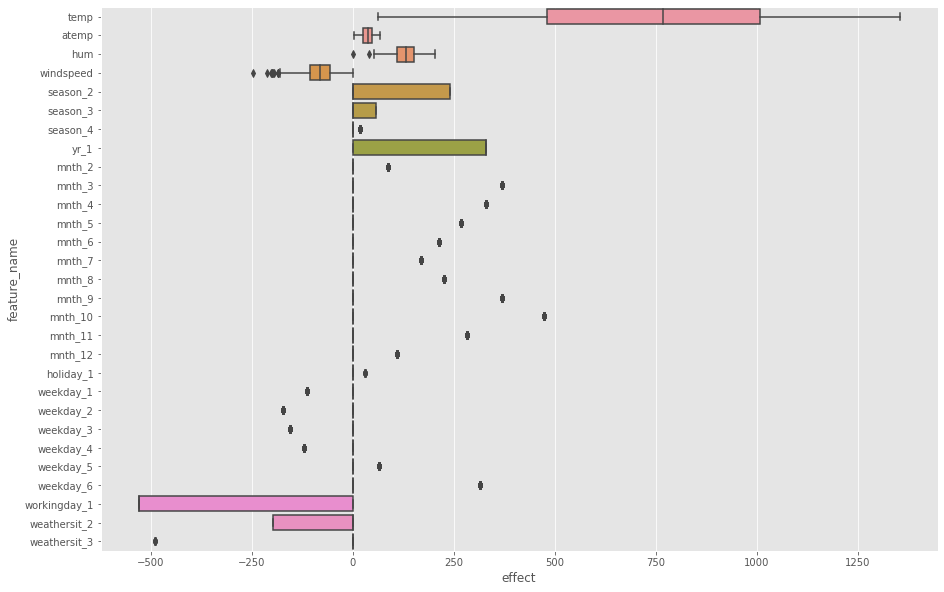

In [19]:
temp_data = []
for j in range(len(features)):
    for i in range(effect_data.shape[0]):
        temp_data.append([features[j], effect_data.iloc[i, j]])

temp_df = pd.DataFrame(columns=['feature_name', 'effect'], data=temp_data)
display(temp_df.head())

plt.figure(figsize=(15, 10))
sns.boxplot(x='effect', y='feature_name', data=temp_df)

- too many outliers for too many features.
    - it would be better to plot them separately.

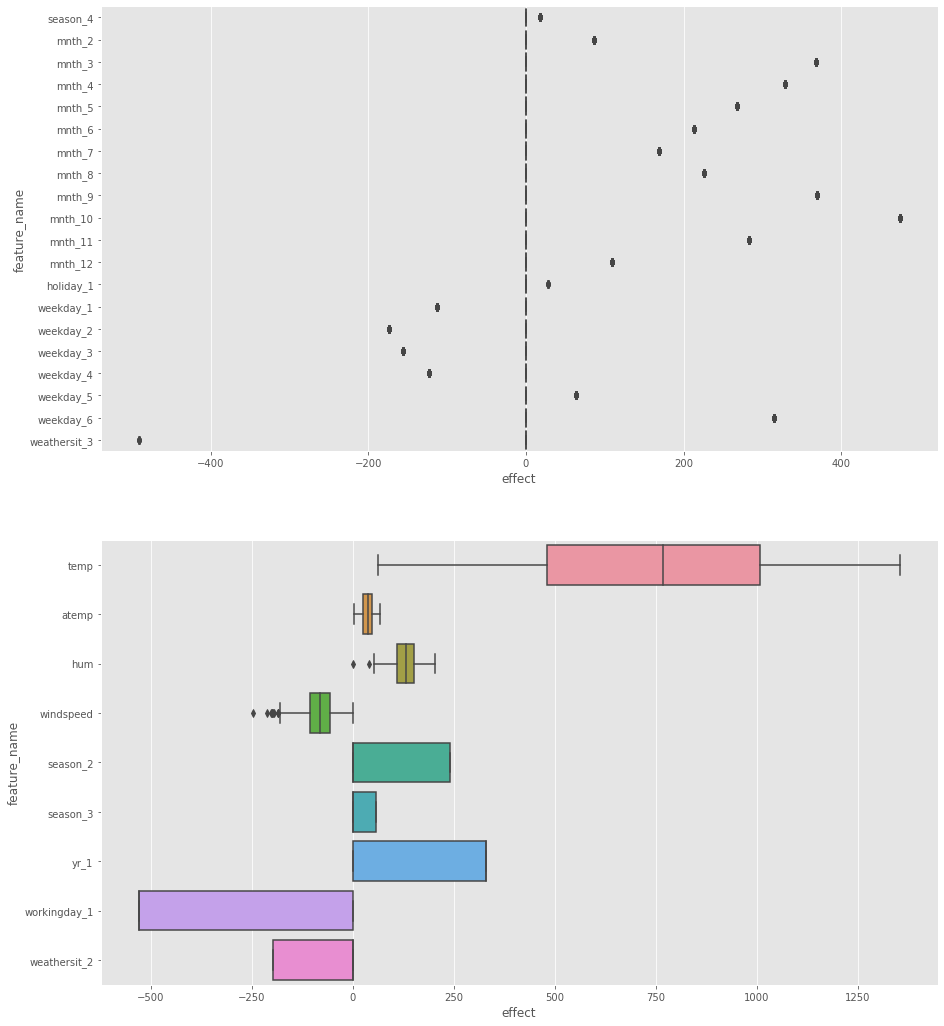

In [20]:
good_features = [
    'temp',
    'atemp',
    'hum',
    'windspeed',
    'season_2',
    'season_3',
    'yr_1',
    'workingday_1',
    'weathersit_2'
]

bad_features = [i for i in effect_data.columns if i not in good_features]

def get_tempdf_given_effect_data(effect_data):
    features = effect_data.columns
    temp_data = []
    for j in range(len(features)):
        for i in range(effect_data.shape[0]):
            temp_data.append([features[j], effect_data.iloc[i, j]])
            
    temp_df = pd.DataFrame(columns=['feature_name', 'effect'], data=temp_data)
    return temp_df

bad_feature_effect_df = get_tempdf_given_effect_data(effect_data.loc[:, bad_features])
good_feature_effect_df = get_tempdf_given_effect_data(effect_data.loc[:, good_features])

fig, ax = plt.subplots(2, 1, figsize=(15, 18))
sns.boxplot(x='effect', y='feature_name', data=bad_feature_effect_df, ax=ax[0])
sns.boxplot(x='effect', y='feature_name', data=good_feature_effect_df, ax=ax[1])